In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import data_path

In [3]:
data = pd.read_parquet(os.path.join(data_path,'SPY_new.parquet'))

In [4]:
df_option = data[data['exdate'] != '2015-12-19']
df_option = df_option[df_option['exdate'] != '2018-12-23']

df_option = df_option[
    (df_option['open_interest'] > 0) &
    #(df_option['gamma'].notnull()) &  # 防止 NaN
    (df_option['best_bid'] > 0) &
    (df_option['best_offer'] > 0) &
    df_option['cp_flag'].isin(['C', 'P'])
]

df_option ['mid_price'] = (df_option ['best_bid'] + df_option ['best_offer']) / 2   

df_option.head()

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,...,index_flag,exchange_d,class,issue_type,industry_group,issuer,div_convention,exercise_style,am_set_flag,mid_price
985,109820,2005-01-11,SFB.FE,0,2005-06-18,2005-01-10,C,135000,0.10,0.20,...,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,0.150
999,109820,2005-01-11,SFB.FZ,0,2005-06-18,2005-01-10,C,130000,0.50,0.55,...,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,0.525
1009,109820,2005-01-11,SFB.IJ,0,2005-09-17,2005-01-10,C,140000,0.15,0.25,...,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,0.200
1018,109820,2005-01-11,SFB.IZ,0,2005-09-17,2005-01-11,C,130000,1.25,1.30,...,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,1.275
1028,109820,2005-01-11,SFB.LJ,0,2005-12-17,2005-01-10,C,140000,0.45,0.55,...,0,1,NaN,%,NaN,SSGA ACTIVE TRUST,NaN,A,NaN,0.500


In [5]:
df_option['date'] = pd.to_datetime(df_option['date'])
df_option = df_option[df_option['date']>='2011-01-01']

In [6]:
import yfinance as yf
import ta 

spy = yf.download("SPY", start="2011-05-02", end="2025-04-04")
df_spy = spy[['Close']].rename(columns={'Close': 'SPY'})
df_spy = df_spy['SPY']
df_spy.dropna(inplace=True)
df_spy = df_spy.reset_index().rename(columns={'Date': 'date', 'SPY': 'SPY'})
df_spy['date'] = pd.to_datetime(df_spy['date'])

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [7]:
df_merged = pd.merge(df_option,df_spy,on='date')
df_merged = df_merged[['date', 'exdate', 'cp_flag', 'strike_price', 'best_bid', 'best_offer', 'mid_price', 'SPY',
                       'volume', 'open_interest', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta',
                       'contract_size']]
df_merged.head()

,date,exdate,cp_flag,strike_price,best_bid,best_offer,mid_price,SPY,volume,open_interest,impl_volatility,delta,gamma,vega,theta,contract_size
0,2011-05-02,2011-05-06,C,126000,10.19,10.33,10.26,105.572075,0,113,0.364297,0.980543,0.009114,0.675369,-11.44478,100
1,2011-05-02,2011-05-06,C,127000,9.19,9.33,9.26,105.572075,0,104,0.332588,0.978891,0.010697,0.722552,-11.20204,100
2,2011-05-02,2011-05-06,C,128000,8.20,8.32,8.26,105.572075,0,3,0.300755,0.976909,0.012761,0.778696,-10.93411,100
3,2011-05-02,2011-05-06,C,129000,7.21,7.33,7.27,105.572075,28,28,0.279665,0.969663,0.017234,0.981348,-12.73111,100
4,2011-05-02,2011-05-06,C,130000,6.21,6.31,6.26,105.572075,73,120,0.236426,0.971413,0.019406,0.933826,-10.29165,100


In [9]:
df_merged['gamma_exposure'] = df_merged['gamma'] *  100 * df_merged['open_interest'] * df_merged['SPY']**2 * 0.01

In [10]:
call_gamma = df_merged[df_merged['cp_flag'] == 'C'].groupby('date')['gamma_exposure'].sum()
put_gamma = df_merged[df_merged['cp_flag'] == 'P'].groupby('date')['gamma_exposure'].sum()

gamma_exposure = pd.DataFrame({'GEX': call_gamma - put_gamma,'GEX_Skew': (call_gamma - put_gamma)/(call_gamma + put_gamma)}).reset_index()


In [11]:
df_sq = pd.read_csv(os.path.join(data_path, 'sqzme.csv'))
df_sq['date'] = pd.to_datetime(df_sq['date'])
gex_sq = df_sq.rename(columns={'gex':'gex_sq'})
gex_sq = gex_sq[['date','gex_sq']]

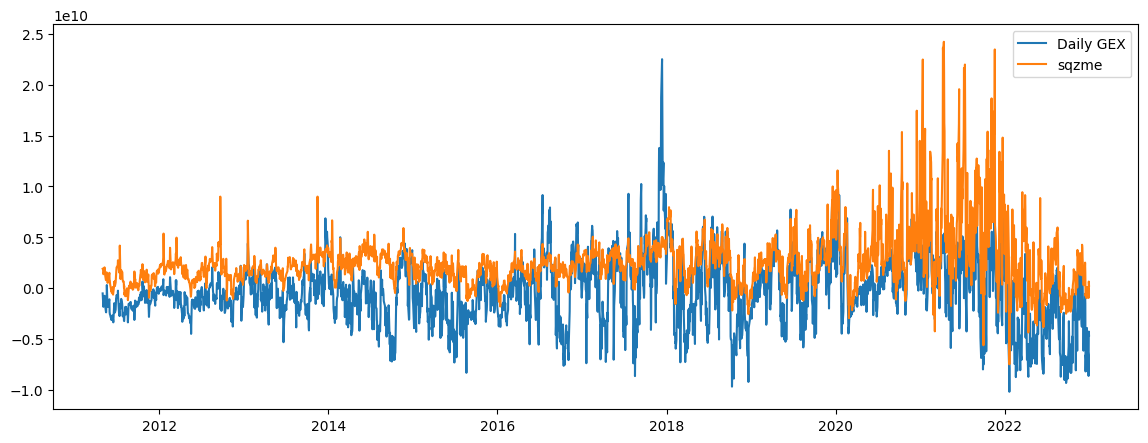

In [12]:
gex_df = gamma_exposure.copy()

df_sq = pd.read_csv(os.path.join(data_path, 'sqzme.csv'))
df_sq['date'] = pd.to_datetime(df_sq['date'])
df_sq = df_sq[df_sq['date'] <= '2022-12-31']

gex_sq = df_sq.rename(columns={'gex':'gex_sq'})
gex_sq = gex_sq[['date','gex_sq']]
gex_sq['date'] = pd.to_datetime(gex_sq['date'])

plt.figure(figsize=(14, 5))


plt.plot(gex_df['date'],gex_df['GEX'], label='Daily GEX')

plt.plot(gex_sq['date'],gex_sq['gex_sq'], label='sqzme')

plt.title('')
plt.legend()
plt.show()
